# XGBoost

In [ ]:
import pandas as pd
import numpy as np
import pickle

import warnings
import scipy.stats as stats
import xgboost as xgb

import shap

import torch
from torch import nn, optim

import category_encoders as ce

from tqdm import tqdm

import gc

import time

In [ ]:
import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

In [ ]:
from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer

from spark_sklearn import GridSearchCV

In [8]:
#levanto data sets
df = pd.read_csv("./cleanedData.csv")
y = df.precio

X = pd.read_csv("./xgboost-x.csv")

In [9]:
aux = X.join(y)
aux = aux.dropna()
aux = aux.sample(n=500, random_state=42)

In [10]:
y_aux = aux.precio
X_aux = aux.drop(['precio'], axis=1, inplace=False)

In [10]:
y_test = pd.DataFrame(y_aux)

In [11]:
data_dmatrix = xgb.DMatrix(data=X_aux,label=y_test)

In [12]:
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X_aux, y_aux, test_size=test_size, random_state=seed)
# fit model no training data

### XGBoost CASO 1 (sin CV)

In [60]:
# fit model no training data
model = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
model.verbose = 1 # ver si esto funca
model.fit(X_train, y_train)
print(model)

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=10,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)


Series.base is deprecated and will be removed in a future version


In [61]:
# make predictions for test data
y_pred = model.predict(X_test)

In [ ]:
y_test = pd.DataFrame(y_test)
y_pred = pd.DataFrame(y_pred)

y_test.fillna(value=0, inplace=True)
y_pred.fillna(value=0, inplace=True)

In [62]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))

RMSE: 1348924.251487


In [ ]:
mae = mean_absolute_error(y_test, y_pred)#(np.nan_to_num(y_test),np.nan_to_num(y_pred))
print("El mean absolute error(MAE) de es {}".format(mae))

### XGBoost CASO 2 (con CV)

In [63]:
#In order to build more robust models, it is common to do a k-fold cross validation

params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1,'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, 
                    params=params, nfold=3, 
                    num_boost_round=50,
                    early_stopping_rounds=10,
                    metrics="rmse", 
                    as_pandas=True, 
                    seed=123)

#KeyError: 'best_msg'
#the error is caused by missing values in X. 
#XGB can handle missing values in the model.fit(X, y) but not in the early stopping rounds, for some unknown reasons.
#https://stackoverflow.com/questions/49649675/xgboost-early-stopping-gives-keyerror-best-msg

In [64]:
print((cv_results["test-rmse-mean"]).tail(1))

49    992972.5625
Name: test-rmse-mean, dtype: float64


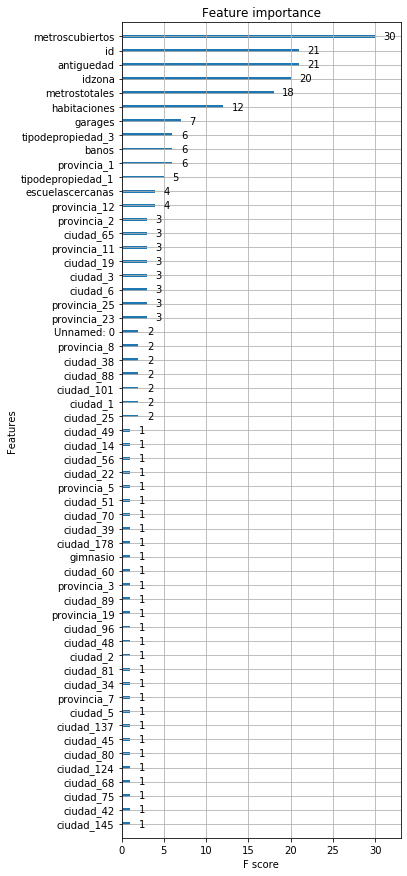

In [70]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [15, 15]
plt.show()

### XGBoost CASO 3 (con RandomizedSearchCV)

In [13]:
# xgboost & RandomizedSearchCV >>> https://gist.github.com/wrwr/3f6b66bf4ee01bf48be965f60d14454d
# xgboost parametros >>> https://xgboost.readthedocs.io/en/latest/parameter.html
# RandomizedSearchCV >>> https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

param_grid = {
        'silent': [False],
        'max_depth': [6, 10, 15, 20],
        'learning_rate': [0.001, 0.01, 0.1, 0.2, 0,3],
#        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
 #       'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
  #      'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
   #     'gamma': [0, 0.25, 0.5, 1.0],
        'reg_alpha': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
#        'n_estimators': [100]
}

In [14]:
clf = xgb.XGBClassifier()
#cv=3 uso la misma que en xgb.cv mas arriba
rs_clf = RandomizedSearchCV(clf, param_grid, n_iter=20,
                            verbose=2, cv=3,
                            scoring='neg_mean_squared_error', random_state=42)

In [17]:
print("Randomized search..")
search_time_start = time.time()
#le paso X_aux, y_aux en vez de el x_train, y_train ( que es un % del total ) porque estoy usando cross validation, 
#si no usara CV deberia tener cuidado y validar si le paso x_train, y_train , xq se podria dar el caso de que 
# como hace el entrenamiento con la totalidad de los datos, luego el x_test, y_test van a dar muy bien y no es el caso.
rs_clf.fit(X_aux, y_aux)
print("Randomized search time:", time.time() - search_time_start)

Randomized search..
Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] silent=False, reg_alpha=5.0, max_depth=6, learning_rate=0.2, colsample_bytree=1.0 


The least populated class in y has only 1 members, which is less than n_splits=3.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  silent=False, reg_alpha=5.0, max_depth=6, learning_rate=0.2, colsample_bytree=1.0, total= 2.5min
[CV] silent=False, reg_alpha=5.0, max_depth=6, learning_rate=0.2, colsample_bytree=1.0 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.5min remaining:    0.0s


[CV]  silent=False, reg_alpha=5.0, max_depth=6, learning_rate=0.2, colsample_bytree=1.0, total= 2.5min
[CV] silent=False, reg_alpha=5.0, max_depth=6, learning_rate=0.2, colsample_bytree=1.0 
[CV]  silent=False, reg_alpha=5.0, max_depth=6, learning_rate=0.2, colsample_bytree=1.0, total= 2.6min
[CV] silent=False, reg_alpha=0.1, max_depth=10, learning_rate=0.1, colsample_bytree=0.8 
[CV]  silent=False, reg_alpha=0.1, max_depth=10, learning_rate=0.1, colsample_bytree=0.8, total= 3.3min
[CV] silent=False, reg_alpha=0.1, max_depth=10, learning_rate=0.1, colsample_bytree=0.8 
[CV]  silent=False, reg_alpha=0.1, max_depth=10, learning_rate=0.1, colsample_bytree=0.8, total= 3.2min
[CV] silent=False, reg_alpha=0.1, max_depth=10, learning_rate=0.1, colsample_bytree=0.8 
[CV]  silent=False, reg_alpha=0.1, max_depth=10, learning_rate=0.1, colsample_bytree=0.8, total= 3.3min
[CV] silent=False, reg_alpha=50.0, max_depth=10, learning_rate=0, colsample_bytree=0.8 
[CV]  silent=False, reg_alpha=50.0, max

[CV]  silent=False, reg_alpha=1.0, max_depth=10, learning_rate=0, colsample_bytree=0.5, total= 2.5min
[CV] silent=False, reg_alpha=100.0, max_depth=10, learning_rate=0.01, colsample_bytree=0.8 
[CV]  silent=False, reg_alpha=100.0, max_depth=10, learning_rate=0.01, colsample_bytree=0.8, total= 2.3min
[CV] silent=False, reg_alpha=100.0, max_depth=10, learning_rate=0.01, colsample_bytree=0.8 
[CV]  silent=False, reg_alpha=100.0, max_depth=10, learning_rate=0.01, colsample_bytree=0.8, total= 2.3min
[CV] silent=False, reg_alpha=100.0, max_depth=10, learning_rate=0.01, colsample_bytree=0.8 
[CV]  silent=False, reg_alpha=100.0, max_depth=10, learning_rate=0.01, colsample_bytree=0.8, total= 2.4min
[CV] silent=False, reg_alpha=10.0, max_depth=10, learning_rate=3, colsample_bytree=0.8 
[CV]  silent=False, reg_alpha=10.0, max_depth=10, learning_rate=3, colsample_bytree=0.8, total= 2.3min
[CV] silent=False, reg_alpha=10.0, max_depth=10, learning_rate=3, colsample_bytree=0.8 
[CV]  silent=False, re

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 147.2min finished


Randomized search time: 9141.903829097748


In [18]:
best_score = rs_clf.best_score_
best_params = rs_clf.best_params_
print("Best score: {}".format(best_score))
print("Best params: ")
for param_name in sorted(best_params.keys()):
    print('%s: %r' % (param_name, best_params[param_name]))

Best score: -1914057809393.6418
Best params: 
colsample_bytree: 0.8
learning_rate: 0.2
max_depth: 10
reg_alpha: 1.0
silent: False


In [4]:
np.sqrt(1914057809393.6418)# 1,383,494.781122662

1383494.781122662

### Resumen experimentos con XGBoost Casos 1, 2 y 3

In [ ]:
XGBoost 

sin CV 1,348,924.251487
params usados -> {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1,'max_depth': 5, 'alpha': 10}

con CV 992,972.5625
params usados -> {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1,'max_depth': 5, 'alpha': 10}

randomSearchCV 1,383,494.781122662 # <- np.sqrt(best_score) == np.sqrt(1914057809393.6418) == 1,383,494.781122662
best params -> colsample_bytree: 0.8, learning_rate: 0.2, max_depth: 10, reg_alpha: 1.0
param_grid utilizada:
param_grid = {
        'silent': [False],
        'max_depth': [6, 10, 15, 20],
        'learning_rate': [0.001, 0.01, 0.1, 0.2, 0, 3],
        'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'reg_alpha': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
}

### XGBoost CASO 4 (con RandomizedSearchCV)

In [1]:
#uso otro param_grid. 
#Por un lado busco valores alrededor de 
#'colsample_bytree': 0.3,'learning_rate': 0.1,'max_depth': 5, 'alpha': 10}
#que son los params del tp de nico.
#
#por otro lado busco valores alrededor de los que me dio la RandomSearchCV anterior

In [12]:
#max_depth: 
#Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit. 

#colsample_bytree: 
#percentage of features used per tree. High value can lead to overfitting.    

param_grid = {
        'silent': [False],
        'max_depth': [2, 5, 7, 10, 15],
        'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25],
        'colsample_bytree': [0.2, 0.3, 0.4, 0.7, 0.8, 0.9],
        'reg_alpha': [0.5, 1.0, 1.5, 9.0, 10.0, 11.0],
}

In [1]:
RandomizedSearchCV()


NameError: name 'RandomizedSearchCV' is not defined

In [15]:
#n_iter:
#Number of parameter settings that are sampled. n_iter trades off runtime vs quality of the solution.

clf = xgb.XGBClassifier()
#cv=3 uso la misma que en xgb.cv mas arriba
rs_clf = RandomizedSearchCV(clf, param_grid, n_iter=40,
                            verbose=2, cv=3,
                            scoring='neg_mean_squared_error', random_state=42)

In [ ]:
print("Randomized search..")
search_time_start = time.time()
#le paso X_aux, y_aux en vez de el x_train, y_train ( que es un % del total ) porque estoy usando cross validation, 
#si no usara CV deberia tener cuidado y validar si le paso x_train, y_train , xq se podria dar el caso de que 
# como hace el entrenamiento con la totalidad de los datos, luego el x_test, y_test van a dar muy bien y no es el caso.
rs_clf.fit(X_aux, y_aux)
print("Randomized search time:", time.time() - search_time_start)

Randomized search..
Fitting 3 folds for each of 40 candidates, totalling 120 fits
[CV] silent=False, reg_alpha=10.0, max_depth=5, learning_rate=0.15, colsample_bytree=0.2 


The least populated class in y has only 1 members, which is less than n_splits=3.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  silent=False, reg_alpha=10.0, max_depth=5, learning_rate=0.15, colsample_bytree=0.2, total= 1.8min
[CV] silent=False, reg_alpha=10.0, max_depth=5, learning_rate=0.15, colsample_bytree=0.2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.8min remaining:    0.0s


[CV]  silent=False, reg_alpha=10.0, max_depth=5, learning_rate=0.15, colsample_bytree=0.2, total= 1.8min
[CV] silent=False, reg_alpha=10.0, max_depth=5, learning_rate=0.15, colsample_bytree=0.2 
[CV]  silent=False, reg_alpha=10.0, max_depth=5, learning_rate=0.15, colsample_bytree=0.2, total= 1.9min
[CV] silent=False, reg_alpha=11.0, max_depth=7, learning_rate=0.15, colsample_bytree=0.9 
[CV]  silent=False, reg_alpha=11.0, max_depth=7, learning_rate=0.15, colsample_bytree=0.9, total= 2.5min
[CV] silent=False, reg_alpha=11.0, max_depth=7, learning_rate=0.15, colsample_bytree=0.9 
[CV]  silent=False, reg_alpha=11.0, max_depth=7, learning_rate=0.15, colsample_bytree=0.9, total= 2.5min
[CV] silent=False, reg_alpha=11.0, max_depth=7, learning_rate=0.15, colsample_bytree=0.9 
[CV]  silent=False, reg_alpha=11.0, max_depth=7, learning_rate=0.15, colsample_bytree=0.9, total= 2.5min
[CV] silent=False, reg_alpha=9.0, max_depth=10, learning_rate=0.15, colsample_bytree=0.3 
[CV]  silent=False, reg_a

[CV]  silent=False, reg_alpha=9.0, max_depth=10, learning_rate=0.2, colsample_bytree=0.8, total= 2.4min
[CV] silent=False, reg_alpha=1.5, max_depth=10, learning_rate=0.25, colsample_bytree=0.7 
[CV]  silent=False, reg_alpha=1.5, max_depth=10, learning_rate=0.25, colsample_bytree=0.7, total= 2.3min
[CV] silent=False, reg_alpha=1.5, max_depth=10, learning_rate=0.25, colsample_bytree=0.7 
[CV]  silent=False, reg_alpha=1.5, max_depth=10, learning_rate=0.25, colsample_bytree=0.7, total= 2.3min
[CV] silent=False, reg_alpha=1.5, max_depth=10, learning_rate=0.25, colsample_bytree=0.7 
[CV]  silent=False, reg_alpha=1.5, max_depth=10, learning_rate=0.25, colsample_bytree=0.7, total= 2.3min
[CV] silent=False, reg_alpha=0.5, max_depth=10, learning_rate=0.05, colsample_bytree=0.3 
[CV]  silent=False, reg_alpha=0.5, max_depth=10, learning_rate=0.05, colsample_bytree=0.3, total= 2.2min
[CV] silent=False, reg_alpha=0.5, max_depth=10, learning_rate=0.05, colsample_bytree=0.3 
[CV]  silent=False, reg_al

In [ ]:
randomSearchCV 1,360,719.781122662 # <- np.sqrt(-best_score)
best params -> colsample_bytree: 0.7, learning_rate: 0.25, max_depth: 10, reg_alpha: 0.5
param_grid utilizada:
param_grid = {
        'silent': [False],
        'max_depth': [2, 5, 7, 10, 15],
        'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25],
        'colsample_bytree': [0.2, 0.3, 0.4, 0.7, 0.8, 0.9],
        'reg_alpha': [0.5, 1.0, 1.5, 9.0, 10.0, 11.0],
}

In [ ]:
#valore para pasarle RandomizedSearchCV en el param "scoring" que seria la fc de evaluacion
#https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
Regression 

‘explained_variance’
metrics.explained_variance_score

‘max_error’
metrics.max_error

‘neg_mean_absolute_error’
metrics.mean_absolute_error

‘neg_mean_squared_error’
metrics.mean_squared_error

‘neg_root_mean_squared_error’
metrics.mean_squared_error

‘neg_mean_squared_log_error’
metrics.mean_squared_log_error

‘neg_median_absolute_error’
metrics.median_absolute_error

‘r2’
metrics.r2_score

‘neg_mean_poisson_deviance’
metrics.mean_poisson_deviance

‘neg_mean_gamma_deviance’
metrics.mean_gamma_deviance